In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import tensorflow as tf

from PIL import Image
import cv2

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


import xgboost
import warnings
warnings.filterwarnings("ignore")


2025-06-06 10:45:21.154238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749206721.548706      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749206721.664170      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
classes = ['NORMAL', 'PNEUMONIA']

all_images = []
all_labels = []
for split in ['train', 'test', 'val']:
    for cls in classes:
        class_dir = os.path.join(base_dir, split, cls)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_images.append(os.path.join(class_dir, img_file))
                    all_labels.append(cls)


In [3]:
from sklearn.model_selection import train_test_split

# Step 1: 40% train, 60% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, 
    test_size=0.6,        # 60% reserved for val+test
    random_state=42, 
    stratify=all_labels
)

# Step 2: 5% val, 55% test from the 60% temp
# 5% out of 60% is 0.0833... (so test_size=0.9167 means 55% test, 0.0833 means 5% val)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=11/12,      # 11/12 of 60% = 55% of total for test, 1/12 of 60% = 5% of total for val
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)}")
print(f"Val: {len(X_val)}")
print(f"Test: {len(X_test)}")


Train: 2342
Val: 292
Test: 3222


In [4]:
import cv2
import numpy as np

IMG_SIZE = (224, 224)
def load_images(image_paths, labels):
    valid_images = []
    valid_labels = []
    for path, label in zip(image_paths, labels):
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            valid_images.append(img)
            valid_labels.append(label)
    return np.array(valid_images), np.array(valid_labels)

train_images, y_train_filtered = load_images(X_train, y_train)
val_images, y_val_filtered = load_images(X_val, y_val)
test_images, y_test_filtered = load_images(X_test, y_test)

print("Filtered dataset sizes:")
print(f"  Train: {len(train_images)} images, {len(y_train_filtered)} labels")
print(f"  Val: {len(val_images)} images, {len(y_val_filtered)} labels")
print(f"  Test: {len(test_images)} images, {len(y_test_filtered)} labels")


Filtered dataset sizes:
  Train: 2342 images, 2342 labels
  Val: 292 images, 292 labels
  Test: 3222 images, 3222 labels


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_encoded = le.fit_transform(y_train_filtered)
val_labels_encoded = le.transform(y_val_filtered)
test_labels_encoded = le.transform(y_test_filtered)


In [6]:
import tensorflow as tf

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet'
)
base_model.trainable = False

# Extract features
train_features = base_model.predict(train_images)
train_features = train_features.reshape(train_features.shape[0], -1)
del train_images

val_features = base_model.predict(val_images)
val_features = val_features.reshape(val_features.shape[0], -1)
del val_images

test_features = base_model.predict(test_images)
test_features = test_features.reshape(test_features.shape[0], -1)
del test_images

print("Feature shapes:")
print("  Train:", train_features.shape)
print("  Val:", val_features.shape)
print("  Test:", test_features.shape)


I0000 00:00:1749206845.310715      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749206845.311487      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1749206849.351000     101 service.cc:148] XLA service 0x79cd80046910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749206849.352209     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749206849.352232     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749206849.541681     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/74 ━━━━━━━━━━━━━━━━━━━━ 14:20 12s/step

I0000 00:00:1749206860.662893     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step
Feature shapes:
  Train: (2342, 25088)
  Val: (292, 25088)
  Test: (3222, 25088)


In [18]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    max_depth=6,
    learning_rate=0.1,
    n_estimators=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    train_features, 
    train_labels_encoded,
    eval_metric=["logloss","error"], 
    eval_set=[(train_features, train_labels_encoded), (val_features, val_labels_encoded)],
    early_stopping_rounds=20,
    verbose=True
)


[0]	validation_0-logloss:0.51324	validation_0-error:0.27028	validation_1-logloss:0.52413	validation_1-error:0.27055


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

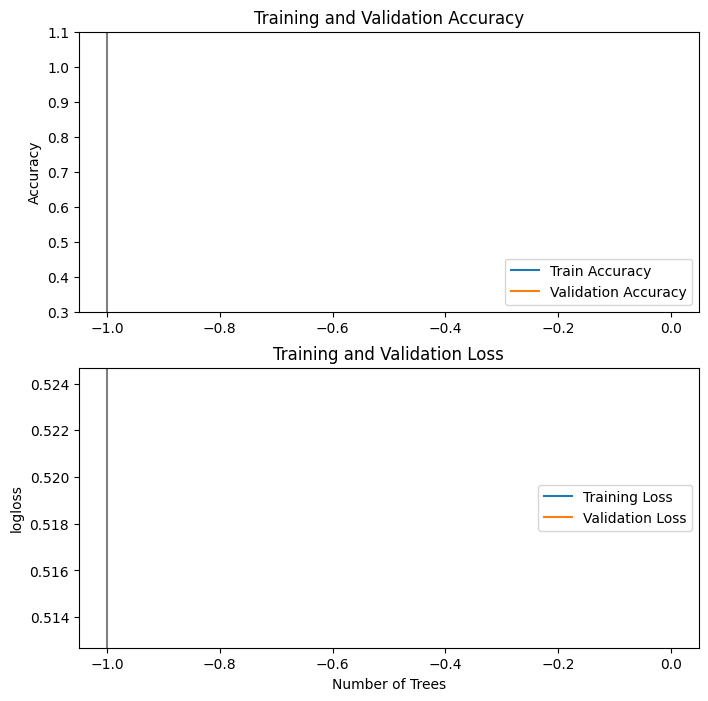

In [20]:
# Extract results
results = model.evals_result()
train_error = results['validation_0']['logloss']
val_error = results['validation_1']['logloss']
train_acc = [1.0 - i for i in results['validation_0']['error']]  # Use 'error'
val_acc = [1.0 - i for i in results['validation_1']['error']]    # Use 'error'


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1.1])
plt.axvline(model.best_iteration-1, color="gray", label="Optimal tree number")
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_error, label='Training Loss')
plt.plot(val_error, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.axvline(model.best_iteration-1, color="gray", label="Optimal tree number")
plt.ylabel('logloss')
plt.xlabel('Number of Trees')
plt.show()


In [16]:
train_predictions = model.predict(train_features)
val_predictions = model.predict(val_features)
print ("Training Accuracy = ", accuracy_score(train_labels_encoded, train_predictions))
print ("Validation Accuracy = ", accuracy_score(val_labels_encoded, val_predictions))


Training Accuracy =  0.7297181895815542
Validation Accuracy =  0.7294520547945206


Evaluating the Algorithm

Accuracy: 		 0.7296710117939168
Precision: 		 0.5324197854523582
Recall: 		 0.7296710117939168
F1 score: 		 0.6156312753373403 



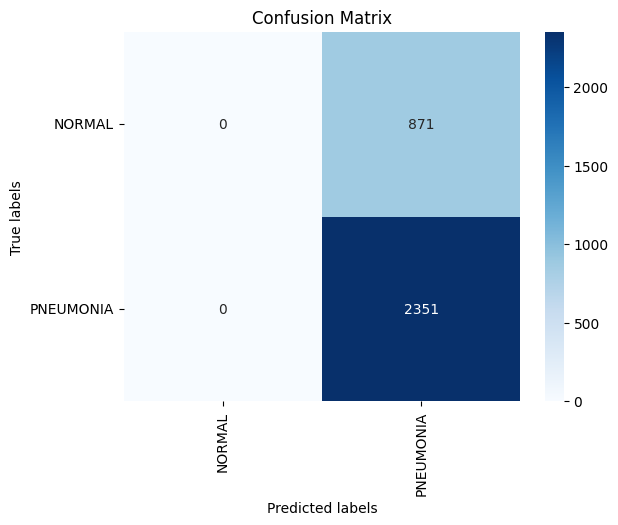

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_test = model.predict(test_features)

print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(test_labels_encoded, y_pred_test))
print('Precision: \t\t', precision_score(test_labels_encoded, y_pred_test, average='weighted'))
print('Recall: \t\t', recall_score(test_labels_encoded, y_pred_test, average='weighted'))
print('F1 score: \t\t', f1_score(test_labels_encoded, y_pred_test, average='weighted'), '\n')

CLASSES = le.classes_

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=test_labels_encoded, predictions=y_pred_test).numpy()
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
